In [59]:
import numpy 
import itertools
import matplotlib.pyplot as plt
import pandas 
import nltk
import csv
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

from stop_words import get_stop_words


In [60]:
stop_words = get_stop_words('spanish')

In [61]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = numpy.trace(cm) / numpy.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = numpy.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Valores reales')
    plt.xlabel('Valores predichos\nExactitud={:0.4f}; Tasa de error={:0.4f}'.format(accuracy, misclass))
    plt.show()

##### Los topicos se encuentran juntos en el dataframe o en una lista, estas funciones separan el encabezado de acuerdo al tema, recibe el dataframe/lista y devuelve una lista con los titulares de un tópico en específico

In [62]:
def splitTopic(topico, lista):
    tema = []
    for i in range(len(lista)):
        if (lista[i][1] == topico):
            tema.append(lista[i][0])
    
    return tema

In [63]:
def separaTopico(topico, df): #Separa todos los encabezados de acuerdo a su tópico
    listTopic = []
    dataArr = numpy.asarray(df)
    for i in range(len(dataArr)):
        if(dataArr[i][1] == topico):
            listTopic.append(dataArr[i][0])
    return listTopic

##### Cuando se tienen las palabras unicas de cada tópico, se eliminan caracteres especiales. Retorna una lista con las palabras que componen el texto

In [64]:
def limpiaTexto(text):
    "List all the word tokens in a text."
    return re.findall('[a-zA-Z0-9\-áéíóúÁÉÍÓÚ@#]{2,254}', text.lower())

##### Esta función busca omite las stop_words en idioma español

In [65]:
def limpiaStopWords(titulares, stop_words):
    newList = []
    for i in range(len(titulares)):
        aux = nltk.word_tokenize(titulares[i])
        filtered_words = [word for word in aux if word not in stop_words] 
        newList.append(" ".join(filtered_words))
        
    return numpy.asarray(newList)

##### Esta función sustituye las tildes de las vocales por unicamente las vocales

In [66]:
def cleanTildes(palabra):
    s = palabra
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    
    return s

In [67]:
def limpiaPalabra(arrPalabras):
    raiz = []
    for i in range(len(arrPalabras)):
        #raiz.append(RaizSingular(cleanTildes(arrPalabras[i])))
        raiz.append(cleanTildes(arrPalabras[i]))
    
    return numpy.asarray(raiz, dtype=str)


##### Cada encabezado corresponde a un documento, esta función separa cada palabra para agregarlas a un solo array

In [68]:
def PalabrasTopico(listTopico): #Devuelve todas las palabras que aparecen en los titulares de las noticias 
    listHeadLines = []
    for i in range(len(listTopico)):
        #aux = nltk.word_tokenize(arrayTopico[i])
        aux = limpiaTexto(listTopico[i])
        #aux = limpiaPalabra()
        for j in range(len(aux)):
            aux2 = aux[j]
            listHeadLines.append(aux2)
            
    return numpy.asarray(listHeadLines)

In [69]:
def Probabilidad(palabrasTopico, palabrasUnicasTopico): #Devuelve un array con la ocurrencias de cada única del tópico
    Prob = numpy.zeros(len(palabrasUnicasTopico))
    for i in range(len(palabrasUnicasTopico)):
        Prob[i] = numpy.sum(palabrasTopico == palabrasUnicasTopico[i])
        Prob[i] = Prob[i] /len(palabrasTopico)
        
    return Prob

##### Recibe el vector de probabilidades y elige la máxima para finalmente devolver el tópico al que pertenece

In [70]:
def Clasificador(arrayProbabilidades):
    indice = numpy.where(arrayProbabilidades == max(arrayProbabilidades))[0][0]
    #print("Max = ", max(arrayProbabilidades))
    if (indice == 0):
        return 'covid'
    if (indice == 1):
        return 'tecnologia'
    if (indice == 2):
        return 'deportes'
    if (indice == 3):
        return 'economia'
    if (indice == 4):
        return 'cultura'
    return 'otros'

##### Devuelve la probabilidad máxima

In [71]:
def MAP(tweet, palabrasCovid, AlfabetoCovid, palabrasTecn, AlfabetoTecn, palabrasDep, AlfabetoDep, palabrasEcon, AlfabetoEcon, palabrasCult, AlfabetoCult):
    T = nltk.word_tokenize(tweet)
    Proba = numpy.ones(5)

    #Covid
    for j in range(len(T)):
        aux = numpy.sum(palabrasCovid == T[j]) + 1
        #print("Palabra = ", T[j], "Apariciones = ", aux)
        Proba[0] = (aux) / (len(AlfabetoCovid) + aux) 
    
    #Tecnologia
    for j in range(len(T)):
        aux = numpy.sum(palabrasTecn == T[j]) 
        #print("Palabra = ", T[j], "Apariciones = ", aux)
        Proba[1] = (aux) / (len(AlfabetoTecn) + aux) 

    #Deportes
    for j in range(len(T)):
        aux = numpy.sum(palabrasDep == T[j]) + 1
        #print("Palabra = ", T[j], "Apariciones = ", aux)
        Proba[2] = (aux) / (len(AlfabetoDep) + aux) 
        
    #Economía
    for j in range(len(T)):
        aux = numpy.sum(palabrasEcon == T[j]) + 1
        #print("Palabra = ", T[j], "Apariciones = ", aux)
        Proba[3] = (aux) / (len(AlfabetoEcon) + aux) 
        
    #Cultura
    for j in range(len(T)):
        aux = numpy.sum(palabrasCult == T[j]) + 1
        #print("Palabra = ", T[j], "Apariciones = ", aux)
        Proba[4] = (aux) / (len(AlfabetoCult) + aux) 

        
    return Clasificador(Proba)
        

#### Esta función remplaza las cadenas tipo URL, ya que conflictuan la clasificación

In [72]:
def limpiaTweet(df):
    listTweets = df.Tweets.values.tolist()
    pattern = re.compile('https?://(?:[-\w./]|(?:%\da-fA-F{2}))+')
    cleanTweets =[]
    
    for tweet in listTweets:
        res = re.findall(pattern, tweet)
        if (len(res) != 0):
            aux = tweet.replace(res[0], '')
            cleanTweets.append(aux)
        else:
            cleanTweets.append(tweet)
            
    for tweet in cleanTweets:
        if(len(tweet) == 0):
            cleanTweets.remove(tweet)
    
    return numpy.asarray(cleanTweets)

In [73]:
def preProcesamiento(listaTitulares):
    titulares = []
    for titular in listaTitulares:
        aux = limpiaTexto(titular)
        titulares.append(str.join(' ', aux))
        
    titularesF1 = []
    for titular in titulares:
        titularesF1.append(str.join('', cleanTildes(titular)))
        
    
    return titularesF1


In [74]:
tweetsPrueba= ['Esto es el primer tweet covid-19', 'este es el segundo de facebook', 'tercer tweet con los goles', 'cuarto tweeet con el petróleo y pib y  estados unidos', 'ultimo lugar con obras de arte y conciertos']
#tweetsPrueba
res = preProcesamiento(tweetsPrueba)
print(res)

['esto es el primer tweet covid-19', 'este es el segundo de facebook', 'tercer tweet con los goles', 'cuarto tweeet con el petroleo pib estados unidos', 'ultimo lugar con obras de arte conciertos']


##### TEST

#### Abrimos el dataset con pandas
Se abre el dataset de titulares y se realiza un preprocesamiento el cual consiste en eliminar tildes y eliminar palabras que tengan una longitud menor a tres 

In [75]:
nombres = ['Titular', 'Tópico']
dataTrain = pandas.read_csv('.//TitularesTrain//titulares.csv', names=nombres)
dataTrain = dataTrain.dropna()
dataTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3926 entries, 0 to 7854
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Titular  3926 non-null   object
 1   Tópico   3926 non-null   object
dtypes: object(2)
memory usage: 92.0+ KB


In [76]:
Y = dataTrain.Tópico.values.tolist()
X = limpiaStopWords(dataTrain.Titular.values.tolist(), stop_words=stop_words)

x, X_test, y, y_test = train_test_split(X, Y, test_size=0.25, random_state=100)

unir = []
for i in range(len(x)):
    unir.append([x[i], y[i]])
    
print("Datos de entrenamiento = ", len(x))

Datos de entrenamiento =  2944


In [77]:
## Preprocesamiento de X_test
resultPreproc = preProcesamiento(X_test)

##### Separamos del dataset por tópicos y a cada encabezado lo separamos por palabra de los documentos eliminando caracteres especiales

In [78]:
palabrasCovid = limpiaPalabra(PalabrasTopico(splitTopic('covid', unir)))
AlfabetoCovid = numpy.unique(palabrasCovid)
#PCov = Probabilidad(palabrasCovid, AlfabetoCovid)
#print("Alfabeto Covid = ", len(AlfabetoCovid))

palabrasTecn = limpiaPalabra(PalabrasTopico(splitTopic('tecnologia', unir)))
AlfabetoTecn = numpy.unique(palabrasTecn)
#PTecn = Probabilidad(palabrasTecn, AlfabetoTecn)

palabrasDep = limpiaPalabra(PalabrasTopico(splitTopic('deportes', unir)))
AlfabetoDep = numpy.unique(palabrasDep)
#PDep = Probabilidad(palabrasDep, AlfabetoDep)
#print("Alfabeto Deportes = ", len(AlfabetoDep))

palabrasEcon = limpiaPalabra(PalabrasTopico(splitTopic('economia', unir)))
AlfabetoEcon = numpy.unique(palabrasEcon)
#PEcon = Probabilidad(palabrasEcon, AlfabetoEcon)
#print("Alfabeto Economía = ", len(AlfabetoEcon))

palabrasCult = limpiaPalabra(PalabrasTopico(splitTopic('cultura', unir)))
AlfabetoCult = numpy.unique(palabrasCult)
#PTecn = Probabilidad(palabrasCult, AlfabetoCult)
#print("Alfabeto Cultura = ", len(AlfabetoCult))

#Alfabeto = numpy.concatenate((AlfabetoCovid, AlfabetoTecn, AlfabetoDep, AlfabetoEcon, AlfabetoCult))
#Alfabeto.shape

##### Obtenemos las probabilidades a priori, haciendo cada una de estas equiprobabloe $ P(C) $

In [79]:
PCovid = 1/5
PTecn = 1/5
PDep = 1/5
PEcon = 1/5
PCult = 1/5

labels = ['Covid', 'Tecnologia', 'Deportes', 'Economia', 'Cultura']

In [80]:
result = []
for i in range(len(X_test)):
    result.append(MAP(resultPreproc[i], palabrasCovid, AlfabetoCovid, palabrasTecn, AlfabetoTecn, palabrasDep, AlfabetoDep, palabrasEcon, AlfabetoEcon, palabrasCult, AlfabetoCult))
    
resultClass = numpy.asarray(result)

#print(resultClass)
#print(len(y_test))



[[181  53  16  31  11]
 [ 16  86   9  10   2]
 [ 30  47 157  28   7]
 [ 13  27  18 193   7]
 [  5  17   2   7   9]]


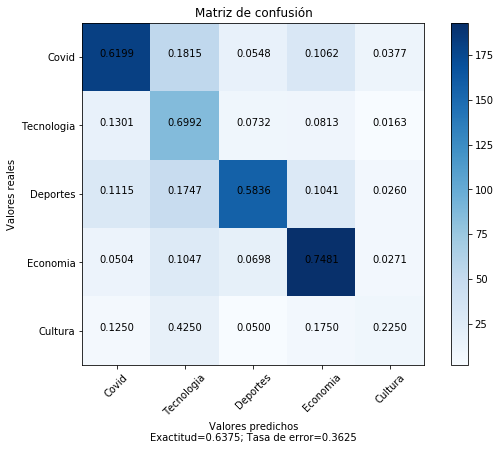

In [81]:
cm = confusion_matrix(y_test, resultClass)
print(cm)
plot_confusion_matrix(cm,
                      labels,
                      title='Matriz de confusión',
                      cmap=None,
                      normalize=True)

### Implementado TF-IDF

In [56]:
vectorizer = TfidfVectorizer(stop_words = stop_words, ngram_range = (1,2), min_df = 3)
X_TFidf = vectorizer.fit_transform(resultPreproc)
#print(vectorizer.get_feature_names()) # Mapeo de matriz de índices de enteros de entidad a nombre de entidad
print(X_TFidf.shape)

(982, 695)
